In [10]:
from os import makedirs
from os.path import join, isdir

import torch
import torchvision

import matplotlib
import matplotlib.pyplot as plt

In [2]:
scale = 4
plots_folder = join("plots")


def save_plot(filename: str, folder_path: str):
    if not isdir(folder_path):
        makedirs(folder_path)
    for extension in ["png", "svg"]:
        if not isdir(join(folder_path, extension)):
            makedirs(join(folder_path, extension))
        plt.savefig(join(folder_path, extension, f"{filename}.{extension}"))

In [3]:
from quantization import quantization_fn


def plot_quantization_function(quantization_bits, range_clip=1, n_values=128):
    weights = torch.linspace(-range_clip, range_clip, n_values)
    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(scale, scale))
    ax.set_xlabel("weight magnitude")
    ax.set_ylabel("weight magnitude quantized")
    for r in [0.001, 0.25, 0.75, 1]:
        weights_quantized = quantization_fn(weights.clone(),
                                            r=r, quantization_bits=quantization_bits, range_clip=range_clip)
        ax.plot(weights, weights_quantized, label=f"$r = {r}$")
    ax.set_title(f"{quantization_bits}-bit quantization function")
    plt.legend()
    save_plot(filename=f"quantization_fn_{quantization_bits}bits", folder_path=plots_folder)
    plt.show()

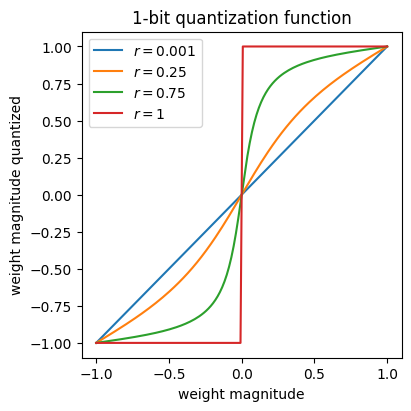

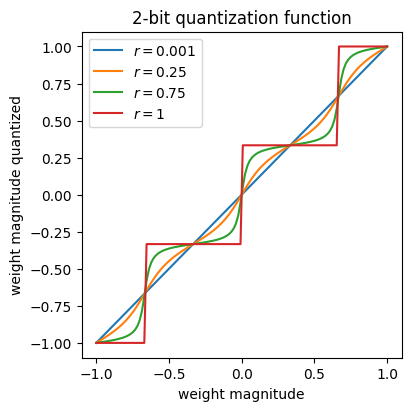

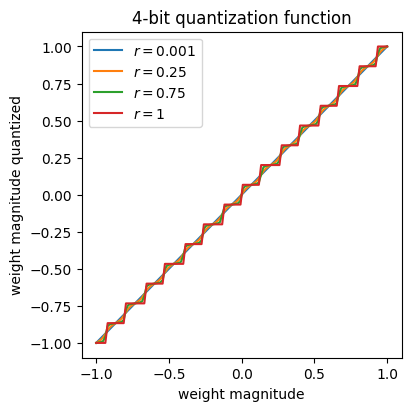

In [4]:
plot_quantization_function(quantization_bits=1)
plot_quantization_function(quantization_bits=2)
plot_quantization_function(quantization_bits=4)

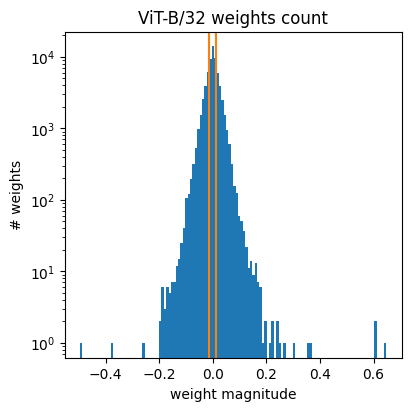

In [5]:
import numpy as np
from utils import get_flattened_weights

pruning_percent = 0.5
model = torchvision.models.vit_b_32()
model.load_state_dict(torch.load(join("models", "weights", "imagenet", "vit_b_32.pth")))
weights = get_flattened_weights(model)
weights = weights[torch.linspace(0, len(weights), steps=2 ** 16, dtype=torch.long)]
left_margin = np.percentile(weights, ((1 - pruning_percent) / 2) * 100)
right_margin = np.percentile(weights, (pruning_percent + (1 - pruning_percent) / 2) * 100)

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(scale, scale))
ax.set_xlabel("weight magnitude")
ax.set_ylabel("# weights")
ax.set_yscale("log")
ax.hist(weights, bins=128)
# ax.hist([weights[weights < left_margin], weights[(weights < left_margin) & (weights > right_margin)], weights[weights > right_margin]], color=["tab:blue", "tab:orange", "tab:blue"], bins=128)
ax.axvline(x=left_margin, color="tab:orange", label='axvline - full height')
ax.axvline(x=right_margin, color="tab:orange", label='axvline - full height')
ax.set_title(f"ViT-B/32 weights count")
save_plot(filename=f"pruned_weights", folder_path=plots_folder)
plt.show()

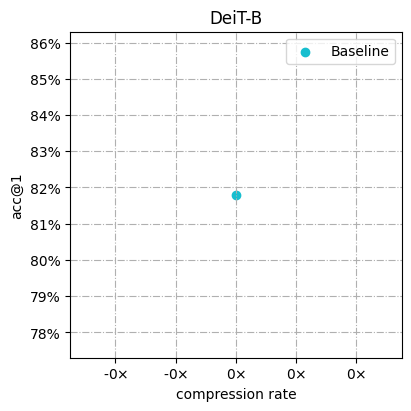

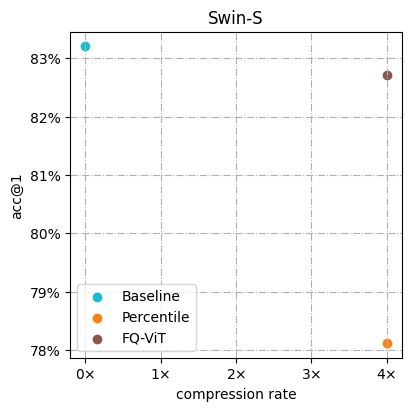

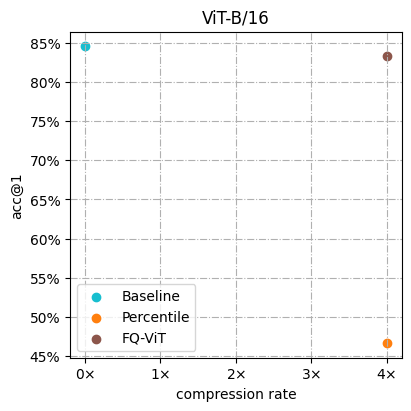

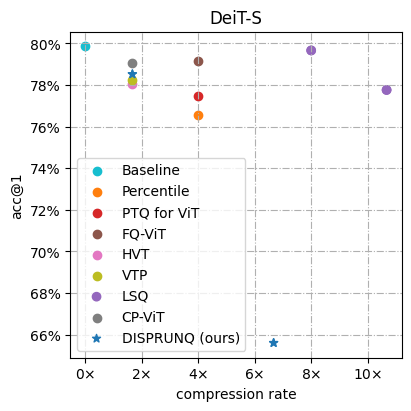

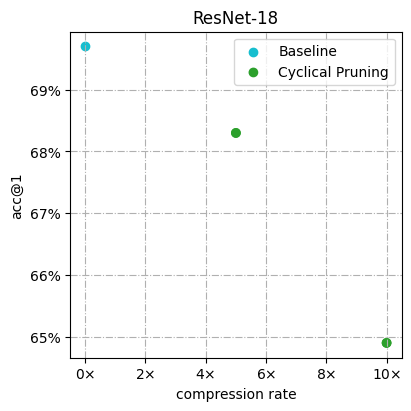

In [117]:
from matplotlib import ticker
import html
from PIL import ImageColor

data = [
    # vit_b_16
    {
        "model": "ViT-B/16",
        "acc": 84.53,
        "cr": 0,
        "author": "Baseline",
    },
    {
        "model": "ViT-B/16",
        "acc": 46.69,
        "cr": 4,
        "author": "Percentile",
    },
    {
        "model": "ViT-B/16",
        "acc": 83.31,
        "cr": 4,
        "author": "FQ-ViT",
    },

    # swin_s
    {
        "model": "Swin-S",
        "acc": 83.2,
        "cr": 0,
        "author": "Baseline",
    },
    {
        "model": "Swin-S",
        "acc": 78.12,
        "cr": 4,
        "author": "Percentile",
    },
    {
        "model": "Swin-S",
        "acc": 82.71,
        "cr": 4,
        "author": "FQ-ViT",
    },

    # deit_s
    {
        "model": "DeiT-S",
        "acc": 79.85,
        "cr": 0,
        "author": "Baseline",
    },
    {
        "model": "DeiT-S",
        "acc": 76.57,
        "cr": 4,
        "author": "Percentile",
    },
    {
        "model": "DeiT-S",
        "acc": 77.49,
        "cr": 4,
        "author": "PTQ for ViT",
    },
    {
        "model": "DeiT-S",
        "acc": 79.17,
        "cr": 4,
        "author": "FQ-ViT",
    },
    {
        "model": "DeiT-S",
        "acc": 78.05,
        "cr": 1.67,
        "author": "HVT",
    },
    {
        "model": "DeiT-S",
        "acc": 78.24,
        "cr": 1.67,
        "author": "VTP",
    },
    {
        "model": "DeiT-S",
        "acc": 79.66,
        "cr": 8,
        "author": "LSQ",
    },
    {
        "model": "DeiT-S",
        "acc": 77.76,
        "cr": 10.67,
        "author": "LSQ",
    },
    {
        "model": "DeiT-S",
        "acc": 79.08,
        "cr": 1.67,
        "author": "CP-ViT",
    },
    {
        "model": "DeiT-S",
        "acc": 78.52,
        "cr": 1.67,
        "author": "DISPRUNQ (ours)",
    },
    {
        "model": "DeiT-S",
        "acc": 65.60,
        "cr": 6.67,
        "author": "DISPRUNQ (ours)",
    },

    # deit_b
    {
        "model": "DeiT-B",
        "acc": 81.80,
        "cr": 0,
        "author": "Baseline",
    },

    # resnet18
    {
        "model": "ResNet-18",
        "acc": 69.70,
        "cr": 0,
        "author": "Baseline",
    },
    {
        "model": "ResNet-18",
        "acc": 68.30,
        "cr": 5,
        "author": "Cyclical Pruning",
    },
    {
        "model": "ResNet-18",
        "acc": 64.90,
        "cr": 10,
        "author": "Cyclical Pruning",
    },
]
authors = list({sample["author"] for sample in data})
models = list({sample["model"] for sample in data})
color_names = [ImageColor.getcolor(c, "RGB") for c in matplotlib.colors.TABLEAU_COLORS.values()]
assert len(authors) <= len(color_names)
colors_authors = {
    author: color_names[i_author]
    for i_author, author in enumerate(authors)
}

for i_model, model in enumerate(models):
    model_data = [sample for sample in data if sample["model"] == model]
    authors = [sample["author"] for sample in model_data]

    fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(scale, scale))
    ax.set_xlabel("compression rate")
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}$\\times$"))
    ax.set_ylabel("acc@1")
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}%"))
    for author in authors:
        author_data = [sample for sample in model_data if sample["author"] == author]
        ax.scatter([sample["cr"] for sample in author_data],
                   [sample["acc"] for sample in author_data],
                   c=np.asarray([colors_authors[author] for _ in author_data])/255,
                   alpha=[1 for _ in range(len(author_data))],
                   marker="*" if "disprunq" in author.lower() else "o",
                   label=author)
    ax.set_title(f"{model}")
    # ax.legend()

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.grid(linestyle='-.')
    save_plot(filename=f"results_imagenet_{model.replace('-', '').replace('/', '')}", folder_path=plots_folder)
    plt.show()